**Table of contents**<a id='toc0_'></a>    
- 1. [Filial-ID eingeben  ](#toc1_)    
- 2. [Preliminaries   ](#toc2_)    
- 3. [Reference Model: DummyRegressor   ](#toc3_)    
- 4. [ML Algorithmen   ](#toc4_)    
  - 4.1. [LinearRegression   ](#toc4_1_)    
  - 4.2. [Lasso   ](#toc4_2_)    
  - 4.3. [RidgeRegression   ](#toc4_3_)    
  - 4.4. [RandomForest   ](#toc4_4_)    
  - 4.5. [GradientBoosting   ](#toc4_5_)    
  - 4.6. [MLP   ](#toc4_6_)    
- 5. [ARIMA, SARIMA   ](#toc5_)    
  - 5.1. [ARIMA   ](#toc5_1_)    
  - 5.2. [SARIMA   ](#toc5_2_)    
- 6. [Prophet   ](#toc6_)    
  - 6.1. [Baseline   ](#toc6_1_)    
  - 6.2. [Promo hinzufügen   ](#toc6_2_)    
  - 6.3. [StateHolidays als Feiertage hinzufügen   ](#toc6_3_)    
  - 6.4. [Open und SchoolHoliday hinzufügen   ](#toc6_4_)    
- 7. [Vorhersage mit dem besten Modell   ](#toc7_)    
- 8. [Bonus: Saisonalität und Stationärität   ](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Filial-ID eingeben   [&#8593;](#toc0_)

In [1]:
id = 1 #int(input("Bitte Filial-ID eingeben: "))

# 2. <a id='toc2_'></a>Preliminaries    [&#8593;](#toc0_)

In [2]:
# %pip install fbprophet

In [3]:
import numpy as np
import pandas as pd

import rms
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from IPython.display import display, HTML
from matplotlib.ticker import FuncFormatter

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# falls bei der Ausgabe von dfs Spalten abgeschnitten werden
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

# Errors should never pass silently. Unless explicitly silenced.
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
def tausender(x):
    return x.replace(",", "X").replace(".", ",").replace("X", ".")
    
    
def custom_formatter(val, pos):
    if val >= 10**9:
        return f'{val / 1e9:,.0f} Mrd'.format(val).replace(",", "X").replace(".", ",").replace("X", ".")
    elif val >= 10**6:
        return f'{x / 1e6:,.0f} Mio'.format(val).replace(",", "X").replace(".", ",").replace("X", ".")
    else:
        return f'{val:,.0f}'.format(val).replace(",", "X").replace(".", ",").replace("X", ".")


def get_rsme(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def get_scores(y_true, y_pred):
    ans={"mae": mean_absolute_error(y_true, y_pred),
         "mape": mean_absolute_percentage_error(y_true, y_pred),
         "rsme": get_rsme(y_true, y_pred),
         "r2": r2_score(y_true, y_pred)}
    
    print(ans)
    return ans


def prepare_x_and_y(data):
    """Prepare X and y to be used by ML models."""

    X = data.drop("Sales".split(), axis=1)
    y = data.Sales

    if "Competition" in data.columns:
        X = X.drop(["CompetitionSince", "CompetitionDistance"], axis=1)
    if "Promo2" in data.columns:
        X = X.drop(["Promo2Since", "PromoInterval"], axis=1)
        
    return X, y


def my_train_test_split(X, y, testsize=8):
    """ Split X and y into trainings and test sets.
    
    Use 8 weeks as default test size."""
    X_train = X.iloc[:-testsize,:]
    X_test = X.iloc[-testsize:, :]
    y_train = y.iloc[:-testsize]
    y_test = y.iloc[-testsize:]

    return X_train, X_test, y_train, y_test


def prepare_prophet_data(data):
    df = data[["Sales"]].reset_index().rename(columns={"index": "ds", "Sales": "y"})
    return df


def split_prophet_data(data):
    df_train = data.iloc[:-8,:]
    df_test = data.iloc[-8:, :]
    return df_train, df_test


def get_date_stuff(data):
    tmp = data
    tmp.loc[:, "Week"] = tmp.index.isocalendar().week 
    tmp.loc[:, "Month"] = tmp.index.month
    tmp.loc[:, "Quarter"] = tmp.index.quarter
    tmp.loc[:, "Year"] = tmp.index.year

    return tmp

In [6]:
results_df = pd.DataFrame(columns="mae mape rsme r2".split())
models_dict = {}
predictions_dict = {}

In [7]:
weekly_data = rms.get_weekly_prediction_df(id)
weekly_data = weekly_data.loc[weekly_data.Sales>0]
weekly_data = get_date_stuff(weekly_data)

X, y = prepare_x_and_y(weekly_data)

X_train, X_test, y_train, y_test = my_train_test_split(X, y)

In [8]:
scaler = StandardScaler()

cols = X_train.columns

X_train_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()

X_train_scaled.loc[:, cols] = scaler.fit_transform(X_train.loc[:, cols])
X_test_scaled.loc[:, cols] = scaler.transform(X_test.loc[:, cols])

In [9]:
tscv = TimeSeriesSplit(test_size=8)

# 3. <a id='toc3_'></a>Reference Model: DummyRegressor    [&#8593;](#toc0_)

In [10]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

y_pred = pd.Series(y_pred, y_test.index)

models_dict["DummyRegressor"] = dummy

In [11]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")))
fig.add_traces(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title="Dummy Regressor")
fig.show()

In [12]:
results_df.loc["DummyRegressor"] = get_scores(y_test, y_pred)

{'mae': 3158.3230000000003, 'mape': 0.13142544357950625, 'rsme': 3710.3607128978715, 'r2': -0.46640203924779855}


# 4. <a id='toc4_'></a>ML Algorithmen    [&#8593;](#toc0_)

## 4.1. <a id='toc4_1_'></a>LinearRegression    [&#8593;](#toc0_)

In [13]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
y_pred = pd.Series(lr.predict(X_test_scaled),  y_test.index)

models_dict["LinearRegression"] = lr
predictions_dict["LinearRegression"] = y_pred

In [14]:
fig = go.Figure()

fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
fig.add_traces(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title="Linear Regression")
fig.show()

In [15]:
results_df.loc["LR"] = get_scores(y_test, y_pred)

{'mae': 1304.4685769945409, 'mape': 0.05061718560327131, 'rsme': 1591.9610241041707, 'r2': 0.7300485579549723}


## 4.2. <a id='toc4_2_'></a>Lasso    [&#8593;](#toc0_)

In [16]:
lasso = LassoCV(n_alphas=100, cv=tscv)

lasso.fit(X_train_scaled, y_train)
y_pred = pd.Series(lasso.predict(X_test_scaled),  y_test.index)

models_dict["Lasso"] = lasso
predictions_dict["Lasso"] = y_pred

In [17]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
fig.add_traces(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title="Lasso")
fig.show()

In [18]:
results_df.loc["Lasso"] = get_scores(y_test, y_pred)

{'mae': 1417.6924231695743, 'mape': 0.05497935195694242, 'rsme': 1602.2677341754095, 'r2': 0.726541791325124}


## 4.3. <a id='toc4_3_'></a>RidgeRegression    [&#8593;](#toc0_)

In [19]:
ridge = RidgeCV(alphas=[0.001, 0.01, 0.1, 0.5, 1, 5, 10], cv=tscv)

ridge.fit(X_train_scaled, y_train)
y_pred = pd.Series(ridge.predict(X_test_scaled),  y_test.index)

models_dict["Ridge"] = ridge
predictions_dict["Ridge"] = y_pred

In [20]:
fig = go.Figure()

fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
fig.add_traces(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title="Ridge")
fig.show()

In [21]:
results_df.loc["Ridge"] = get_scores(y_test, y_pred)

{'mae': 1307.2041196440564, 'mape': 0.05070461452743065, 'rsme': 1592.3160876826694, 'r2': 0.7299281270995147}


## 4.4. <a id='toc4_4_'></a>RandomForest    [&#8593;](#toc0_)

In [22]:
forest = RandomForestRegressor(n_estimators=1000, random_state=420)

forest.fit(X_train_scaled, y_train)
y_pred = pd.Series(forest.predict(X_test_scaled),  y_test.index)

models_dict["RandomForest"] = forest
predictions_dict["RandomForest"] = y_pred

In [23]:
fig = go.Figure()

fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
fig.add_traces(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title="Random Forest")
fig.show()

In [24]:
results_df.loc["RandomForest"] = get_scores(y_test, y_pred)

{'mae': 904.9351250000004, 'mape': 0.03374651300566965, 'rsme': 1191.775275804703, 'r2': 0.8487102402545683}


## 4.5. <a id='toc4_5_'></a>GradientBoosting    [&#8593;](#toc0_)

In [25]:
grad = GradientBoostingRegressor()
grad.fit(X_train_scaled, y_train)
y_pred = pd.Series(grad.predict(X_test_scaled),  y_test.index)
models_dict["GradientBoosting"] = grad
predictions_dict["GradientBoosting"] = y_pred

In [26]:
fig = go.Figure()

fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
fig.add_traces(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title="Gradient Boosting")
fig.show()

In [27]:
results_df.loc["GradientBoosting"] = get_scores(y_test, y_pred)

{'mae': 872.9884575271808, 'mape': 0.03328774362552597, 'rsme': 1211.302917850939, 'r2': 0.843711754043075}


## 4.6. <a id='toc4_6_'></a>MLP    [&#8593;](#toc0_)

In [28]:
# mlp = MLPRegressor(max_iter=20000, random_state=420)
# mlp.fit(X_train, y_train)
# y_pred = pd.Series(mlp.predict(X_test),  y_test.index)
# models_dict["MLP"] = mlp
# predictions_dict["MLP"] = y_pred

In [29]:
# fig = go.Figure()

# fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
# fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
# fig.add_traces(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
# fig.update_layout(title="MLP")
# fig.show()

In [30]:
# results_df.loc["MLP"] = get_scores(y_test, y_pred)

# 5. <a id='toc5_'></a>ARIMA, SARIMA    [&#8593;](#toc0_)

## 5.1. <a id='toc5_1_'></a>ARIMA    [&#8593;](#toc0_)

In [31]:
y_train_tmp = y_train.copy()
y_train_tmp.index = pd.DatetimeIndex(y_train_tmp.index.values, freq=y_train_tmp.index.inferred_freq)

In [32]:
ARIMAmodel = ARIMA(y_train_tmp, order = (5, 1, 2))
ARIMAmodel = ARIMAmodel.fit()

models_dict["ARIMA"] = ARIMAmodel


y_pred = ARIMAmodel.get_forecast(len(y_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = y_test.index
y_pred_out = y_pred_df["Predictions"] 

fig = go.Figure()
fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
fig.add_traces(go.Scatter(x=y_pred_out.index, y=y_pred_out.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title="ARIMA")
fig.show()



c:\Users\tk\anaconda3\envs\test_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\tk\anaconda3\envs\test_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\tk\anaconda3\envs\test_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [33]:
results_df.loc["ARIMA"] = get_scores(y_test, y_pred_out)
predictions_dict["ARIMA"] = y_pred_out

{'mae': 2584.048995684284, 'mape': 0.1077880602107697, 'rsme': 3237.9267447780326, 'r2': -0.11674708702695025}


## 5.2. <a id='toc5_2_'></a>SARIMA    [&#8593;](#toc0_)

In [34]:
SARIMAmodel = SARIMAX(y_train_tmp, order = (2, 1, 2))
SARIMAmodel = SARIMAmodel.fit()

In [35]:
y_pred = SARIMAmodel.get_forecast(len(y_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = y_test.index
y_pred_out = y_pred_df["Predictions"] 

In [36]:
results_df.loc["SARIMA"] = get_scores(y_test, y_pred_out)
models_dict["SARIMA"] = SARIMAmodel
predictions_dict["SARIMA"] = y_pred_out

{'mae': 2754.022971295487, 'mape': 0.10313509740227442, 'rsme': 3304.1640388898127, 'r2': -0.1629043384361073}


In [37]:
fig = go.Figure()

fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
fig.add_traces(go.Scatter(x=y_pred_out.index, y=y_pred_out.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title="SARIMA")
fig.show()

# 6. <a id='toc6_'></a>Prophet    [&#8593;](#toc0_)

In [38]:
df = prepare_prophet_data(weekly_data)
df_train, df_test = split_prophet_data(df)

In [39]:
df_train

,ds,y
0,2013-01-13,32952
1,2013-01-20,25978
2,2013-01-27,33071
3,2013-02-03,28693
4,2013-02-10,35771
...,...,...
120,2015-05-03,28627
121,2015-05-10,29272
122,2015-05-17,19705
123,2015-05-24,27740


## 6.1. <a id='toc6_1_'></a>Baseline    [&#8593;](#toc0_)

In [40]:
m = Prophet(interval_width = 0.95)
m.fit(df_train)

future = m.make_future_dataframe(periods=8, freq="W")

forecast = m.predict(future)

models_dict["ProphetBase"] = m
predictions_dict["ProphetBase"] = pd.DataFrame({"yhat": forecast.iloc[-8:, :].yhat, "ds": forecast.iloc[-8:, :].ds}).set_index("ds").yhat
results_df.loc["ProphetBase"] = get_scores(df_test.drop("ds", axis=1), forecast.iloc[-8:, :].yhat)

11:50:41 - cmdstanpy - INFO - Chain [1] start processing
11:50:41 - cmdstanpy - INFO - Chain [1] done processing


{'mae': 2916.3775822001962, 'mape': 0.1105909180592678, 'rsme': 3312.839764594161, 'r2': -0.16901921911969398}


In [41]:
fig = plot_plotly(m, forecast)
fig.update_layout(title="ProphetBase")

## 6.2. <a id='toc6_2_'></a>Promo hinzufügen    [&#8593;](#toc0_)

Promo gibt an, ob in der Woche eine Promo-Woche war. Promo findet normalerweise im zweiwöchentlichen Rhythmus jeweils von Montag bis Freitag statt. Manchmal gibt es auch zwei Wochen hintereinander in denen Promo stattfindet bzw. nicht stattfindet. In Promo-Wochen steigt der Umsatz im Gegensatz zu Nicht-Promowochen. Damit stellt Promo eine saisonale Komponente dar, die Aufschluss über die zu erwartende Umsatzentwicklung gibt.

In [42]:
def add_promo(data):
    data.loc[:, "promo"] = (data.Promo==5)
    return data

In [43]:
weekly_data_promo = add_promo(weekly_data)

df = weekly_data_promo[["Sales", "promo"]].reset_index().rename(columns={"index": "ds", "Sales": "y"})
df_train, df_test = split_prophet_data(df)

m = Prophet(weekly_seasonality=False, interval_width = 0.95)
m.add_seasonality(name='promo', period=7, fourier_order=3, condition_name='promo')
m.fit(df_train)

future = m.make_future_dataframe(periods=8, freq="W")
future["promo"] = df["promo"]
forecast = m.predict(future)

models_dict["ProphetPromo"] = m
predictions_dict["ProphetPromo"] = pd.DataFrame({"yhat": forecast.iloc[-8:, :].yhat, "ds": forecast.iloc[-8:, :].ds}).set_index("ds").yhat
results_df.loc["ProphetPromo"] = get_scores(df_test.y, forecast.iloc[-8:, :].yhat)

11:50:41 - cmdstanpy - INFO - Chain [1] start processing
11:50:42 - cmdstanpy - INFO - Chain [1] done processing


{'mae': 1173.6638327430992, 'mape': 0.044568203806422325, 'rsme': 1399.2428211311665, 'r2': 0.7914515505883971}


In [44]:
fig = plot_plotly(m, forecast)
fig.update_layout(title="ProphetPromo")

## 6.3. <a id='toc6_3_'></a>StateHolidays als Feiertage hinzufügen    [&#8593;](#toc0_)

StateHoliday gibt an, ob ein Feiertag war oder nicht. Prophet bietet die Möglichkeit, Feiertage mit in die Modellbildung einfließen zu lassen.

In [45]:
holidays_a = (weekly_data["StateHoliday_a"]>=1)
holidays_a = pd.DataFrame({"holiday": "a", "ds": holidays_a[holidays_a].index.to_series()})
holidays_b = (weekly_data["StateHoliday_b"]>=1)
holidays_b = pd.DataFrame({"holiday": "b", "ds": holidays_b[holidays_b].index.to_series()})
holidays_c = (weekly_data["StateHoliday_c"]>=1)
holidays_c = pd.DataFrame({"holiday": "c", "ds": holidays_c[holidays_c].index.to_series()})

holidays = pd.concat((holidays_a, holidays_b , holidays_c))

In [46]:
m = Prophet(weekly_seasonality=False, interval_width = 0.95, holidays=holidays)
m.add_seasonality(name='promo', period=7, fourier_order=4, condition_name='promo')
m.fit(df_train)

future = m.make_future_dataframe(periods=8, freq="W")
future["promo"] = df["promo"]

forecast = m.predict(future)

models_dict["ProphetHolidays"] = m
predictions_dict["ProphetHolidays"] = pd.DataFrame({"yhat": forecast.iloc[-8:, :].yhat, "ds": forecast.iloc[-8:, :].ds}).set_index("ds").yhat
results_df.loc["ProphetStateHolidays"] = get_scores(df_test.drop(["ds", "promo"], axis=1), forecast.iloc[-8:, :].yhat)

11:50:42 - cmdstanpy - INFO - Chain [1] start processing


11:50:42 - cmdstanpy - INFO - Chain [1] done processing


{'mae': 1038.4455572222014, 'mape': 0.03899022844975712, 'rsme': 1266.7273445468163, 'r2': 0.8290822836071798}


In [47]:
fig = plot_plotly(m, forecast)
fig.update_layout(title="ProphetHolidays")

In [48]:
# results_df.loc["ProphetStateHolidays"] = get_scores(df_test.drop(["ds", "promo"], axis=1), forecast.iloc[-8:, :].yhat)

## 6.4. <a id='toc6_4_'></a>Open und SchoolHoliday hinzufügen    [&#8593;](#toc0_)

In [49]:
weekly_data

,Sales,Open,Promo,SchoolHoliday,isHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,Week,Month,Quarter,Year,promo
2013-01-13,32952,6,5,5,0,0,0,0,2,1,1,2013,True
2013-01-20,25978,6,0,0,0,0,0,0,3,1,1,2013,False
2013-01-27,33071,6,5,0,0,0,0,0,4,1,1,2013,True
2013-02-03,28693,6,0,0,0,0,0,0,5,2,1,2013,False
2013-02-10,35771,6,5,0,0,0,0,0,6,2,1,2013,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-28,21823,6,0,0,0,0,0,0,26,6,2,2015,False
2015-07-05,31175,6,5,0,0,0,0,0,27,7,3,2015,True
2015-07-12,23041,6,0,0,0,0,0,0,28,7,3,2015,False
2015-07-19,28548,6,5,0,0,0,0,0,29,7,3,2015,True


In [50]:
df = weekly_data[["Sales", "promo", "Open", "SchoolHoliday"]].reset_index().rename(columns={"index": "ds", "Sales": "y"})
df_train = df.iloc[:-8,:]
df_test = df.iloc[-8:, :]

In [51]:
m = Prophet(weekly_seasonality=False, interval_width=0.95, holidays=holidays)
m.add_seasonality(name='promo', period=7, fourier_order=20, condition_name='promo')
m.add_regressor("Open")
m.add_regressor("SchoolHoliday")
m.fit(df_train)

future = m.make_future_dataframe(periods=8, freq="W")
future[["promo", "Open", "SchoolHoliday"]] = df[["promo", "Open", "SchoolHoliday"]]

forecast = m.predict(future)
forecast.loc[forecast.yhat<0, "yhat"] = 0

models_dict["ProphetOpen"] = m
predictions_dict["ProphetOpen"] = pd.DataFrame({"yhat": forecast.iloc[-8:, :].yhat, "ds": forecast.iloc[-8:, :].ds}).set_index("ds").yhat
results_df.loc["ProphetOpen"] = get_scores(df_test.drop(["ds", "promo", "Open", "SchoolHoliday"], axis=1), forecast.iloc[-8:, :].yhat)

11:50:42 - cmdstanpy - INFO - Chain [1] start processing
11:50:42 - cmdstanpy - INFO - Chain [1] done processing


{'mae': 1127.3512391640934, 'mape': 0.04263219358171116, 'rsme': 1318.2671424251198, 'r2': 0.8148909528396601}


In [52]:
fig = plot_plotly(m, forecast)
fig.update_layout(title="ProhetOpen")

In [53]:
# results_df.loc["ProphetOpen"] = get_scores(df_test.drop(["ds", "promo", "Open", "SchoolHoliday"], axis=1), forecast.iloc[-8:, :].yhat)

# 7. <a id='toc7_'></a>Vorhersage mit dem besten Modell    [&#8593;](#toc0_)

In [54]:
results_df

,mae,mape,rsme,r2
DummyRegressor,3158.323000,0.131425,3710.360713,-0.466402
LR,1304.468577,0.050617,1591.961024,0.730049
Lasso,1417.692423,0.054979,1602.267734,0.726542
Ridge,1307.204120,0.050705,1592.316088,0.729928
RandomForest,904.935125,0.033747,1191.775276,0.848710
GradientBoosting,872.988458,0.033288,1211.302918,0.843712
ARIMA,2584.048996,0.107788,3237.926745,-0.116747
SARIMA,2754.022971,0.103135,3304.164039,-0.162904
ProphetBase,2916.377582,0.110591,3312.839765,-0.169019
ProphetPromo,1173.663833,0.044568,1399.242821,0.791452


In [55]:
best_model_name = results_df.rsme.idxmin()
best_model = models_dict[best_model_name]
best_model

RandomForestRegressor(n_estimators=1000, random_state=420)

In [57]:
y_pred = predictions_dict[best_model_name]

fig = go.Figure()

fig.add_traces(go.Scatter(x=y_train.index, y=y_train.values, mode='lines+markers', name = "y_train"))
fig.add_traces(go.Scatter(x=y_test.index, y=y_test.values, mode='lines+markers', name = "y_test", line=dict(color="green")) )
fig.add_traces(go.Scatter(x=y_pred.index, y=y_pred.values, mode='lines+markers', name = "y_pred", line=dict(color="red")))
fig.update_layout(title=best_model_name)
fig.show()

In [ ]:
results_df.loc[best_model_name, :]

mae      904.935125
mape       0.033747
rsme    1191.775276
r2         0.848710
Name: RandomForest, dtype: float64

In [58]:
y_pred

2015-06-07    27852.992
2015-06-14    22360.482
2015-06-21    28413.343
2015-06-28    22579.858
2015-07-05    28546.420
2015-07-12    22975.513
2015-07-19    28444.689
2015-07-26    22904.608
dtype: float64

# 8. <a id='toc8_'></a>Bonus: Saisonalität und Stationärität    [&#8593;](#toc0_)
Die abschließenden Grafiken sind je nach Filiale einigermaßen schwer zu interpretieren. Sie können jedoch Aufschluss über die Saisonalität und Stationärität in den Daten der vorliegenden Filiale geben. Dies könnte man z.B. nutzen, um die (S)AR(i)MA Modelle zu tunen und versuchen deren Ergebnisse zu verbessern.

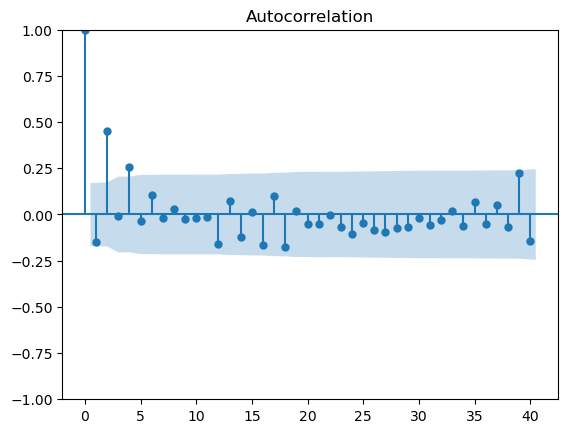

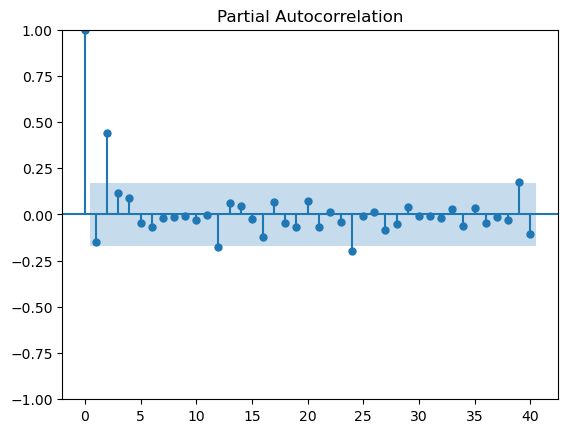

In [59]:
plot_acf(weekly_data.Sales, lags=40)
plot_pacf(weekly_data.Sales, lags=40)

plt.show()

In [60]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales, mode='lines+markers', name = "Sales"))
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales.rolling(window=12).mean() , mode='lines', name = "rolling mean")) 
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales.rolling(window=12).std() , mode='lines', name = "rolling std"))
fig.update_layout(title="Sales, rolling mean, rolling std")
fig.show()

In [61]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales.diff() , mode='lines+markers', name = "Sales"))
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales.diff().rolling(window=12).mean() , mode='lines', name = "rolling mean"))
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales.diff().rolling(window=12).std() , mode='lines', name = "rolling std"))
fig.update_layout(title="Sales.diff(), rolling mean, rolling std")
fig.show()

In [62]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales.diff().diff() , mode='lines+markers', name = "Sales"))
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales.diff().diff().rolling(window=12).mean() , mode='lines', name = "rolling mean"))
fig.add_traces(go.Scatter(x=weekly_data.index, y=weekly_data.Sales.diff().rolling(window=12).std() , mode='lines', name = "rolling std"))
fig.update_layout(title="Sales.diff().diff(), rolling mean, rolling std")
fig.show()